In [19]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval

experiment_name = "b9_q30_s5500_b500_pbo1000_10_w30"
show_fqi = True; show_pbo_linear = False; show_pbo_deep = True
weighted_by_sample = True
max_bellman_iterations = 9
max_bellman_iterations_validation = max_bellman_iterations + 10
seeds = range(1, 21)

p = json.load(open(f"figures/{experiment_name}/parameters.json"))

n_states_x = p["n_states_x"]
n_states_v = p["n_states_v"]
n_seeds = len(seeds)
ticks_freq = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [20]:
if show_fqi:
    fqi_q = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v, 2))
    fqi_v = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v))

    for idx_seed, seed in enumerate(seeds):
        fqi_q[idx_seed] = np.load(f"figures/{experiment_name}/FQI/{max_bellman_iterations}_Q_{seed}.npy")
        fqi_v[idx_seed] = np.load(f"figures/{experiment_name}/FQI/{max_bellman_iterations}_V_{seed}.npy")

optimal_q = np.load(f"figures/data/optimal/Q.npy")
optimal_v = np.load(f"figures/data/optimal/V.npy")

if show_pbo_linear:
    pbo_linear_q = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v, 2))
    pbo_linear_v = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v))

    for idx_seed, seed in enumerate(seeds):
        pbo_linear_q[idx_seed] = np.load(f"figures/{experiment_name}/PBO_linear/{max_bellman_iterations}_Q_{seed}.npy")
        pbo_linear_v[idx_seed] = np.load(f"figures/{experiment_name}/PBO_linear/{max_bellman_iterations}_V_{seed}.npy")

if show_pbo_deep:
    pbo_deep_q = np.zeros((n_seeds, max_bellman_iterations_validation + 1, n_states_x, n_states_v, 2))
    pbo_deep_v = np.zeros((n_seeds, max_bellman_iterations_validation + 1, n_states_x, n_states_v))

    for idx_seed, seed in enumerate(seeds):
        pbo_deep_q[idx_seed] = np.load(f"figures/{experiment_name}/PBO_deep/{max_bellman_iterations}_Q_{seed}.npy")
        pbo_deep_v[idx_seed] = np.load(f"figures/{experiment_name}/PBO_deep/{max_bellman_iterations}_V_{seed}.npy")

if weighted_by_sample:
    samples_mask = np.load(f"figures/{experiment_name}/samples_count.npy")
    samples_mask_q_format = np.repeat(samples_mask[:, :, None], 2, axis=-1)
else:
    samples_mask = 1
    samples_mask_q_format = 1

### Distances with the optimal Q function

In [21]:
if show_fqi:
    fqi_q_mean = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
    fqi_q_std = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
    fqi_q_confidence_interval = confidence_interval(fqi_q_mean, fqi_q_std, n_seeds)

if show_pbo_linear:
    pbo_linear_q_mean = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
    pbo_linear_q_std = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
    pbo_linear_q_confidence_interval = confidence_interval(pbo_linear_q_mean, pbo_linear_q_std, n_seeds)

if show_pbo_deep:
    pbo_deep_q_mean = np.sqrt(np.mean(np.square(pbo_deep_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).mean(axis=0)
    pbo_deep_q_std = np.sqrt(np.mean(np.square(pbo_deep_q - optimal_q) * samples_mask_q_format, axis=(2, 3, 4))).std(axis=0)
    pbo_deep_q_confidence_interval = confidence_interval(pbo_deep_q_mean, pbo_deep_q_std, n_seeds)

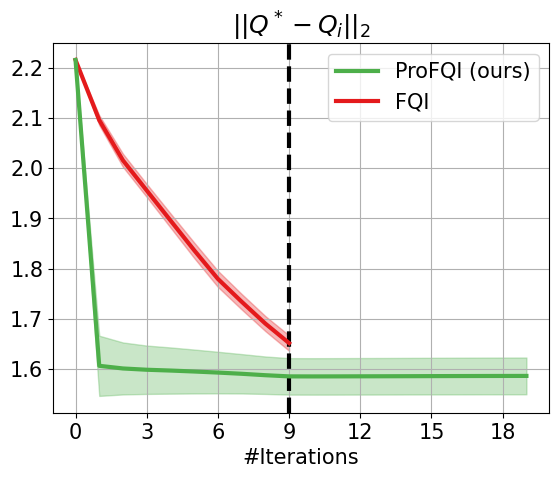

In [22]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_q_mean[:-1], label="linear PBO", color="blue", zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, :-1], pbo_linear_q_confidence_interval[1, :-1], color="blue", alpha=0.3)

    # plt.hlines(pbo_linear_q_mean[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="linear PBO fixed point", zorder=3)
    # plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, -1], pbo_linear_q_confidence_interval[1, -1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_q_mean, label="ProFQI (ours)", color=colors["ProFQI"], zorder=8)
    plt.fill_between(iterations_validation, pbo_deep_q_confidence_interval[0], pbo_deep_q_confidence_interval[1], color=colors["ProFQI"], alpha=0.3)

if show_fqi:
    plt.plot(iterations, fqi_q_mean, label="FQI", color=colors["FQI"], zorder=6)
    plt.fill_between(iterations, fqi_q_confidence_interval[0], fqi_q_confidence_interval[1], color=colors["FQI"], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| Q^* - Q_i ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_Q_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Visualization of the policies at iteration max_bellman_iterations

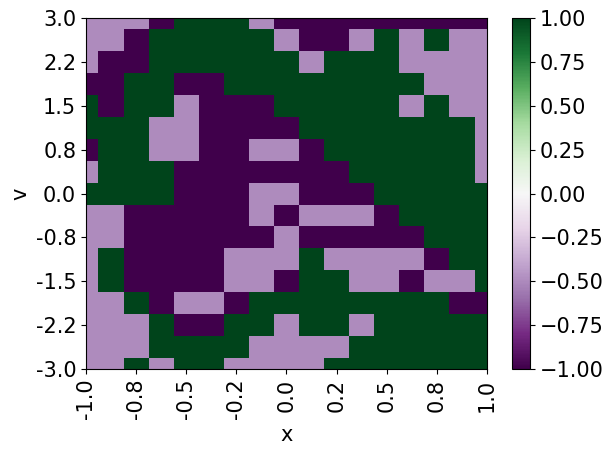

In [23]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_pi_weighted_average = (2 * ((optimal_q[:, :, 1] > optimal_q[:, :, 0])).astype(float) - 1) + (optimal_q[:, :, 1] == optimal_q[:, :, 0]).astype(float) / 2
# optimal_pi_weighted_average *= samples_mask

q_visu_mesh.set_values(optimal_pi_weighted_average)
q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
_ = plt.savefig(f"figures/{experiment_name}/optimal_pi.pdf", bbox_inches='tight')

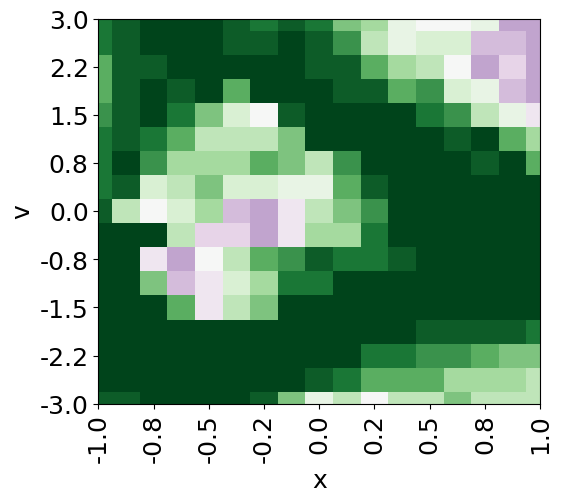

In [51]:
if show_fqi:
    fqi_left_q = fqi_q[:, -1, :, :, 0]
    fqi_right_q = fqi_q[:, -1, :, :, 1]
    fqi_pi_weighted_average = (2 * (fqi_right_q > fqi_left_q).mean(axis=0) - 1)
    # fqi_pi_weighted_average *= samples_mask

    q_visu_mesh.set_values(fqi_pi_weighted_average)
    q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
    _ = plt.savefig(f"figures/{experiment_name}/fqi_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

In [25]:
if show_pbo_linear:
    pbo_linear_left_q = pbo_linear_q[:, max_bellman_iterations, :, :, 0]
    pbo_linear_right_q = pbo_linear_q[:, max_bellman_iterations, :, :, 1]
    pbo_linear_pi_weighted_average = (2 * (pbo_linear_right_q > pbo_linear_left_q).mean(axis=0) - 1)
    # pbo_linear_pi_weighted_average *= samples_mask

    q_visu_mesh.set_values(pbo_linear_pi_weighted_average)
    q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
    _ = plt.savefig(f"figures/{experiment_name}/PBO_linear_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

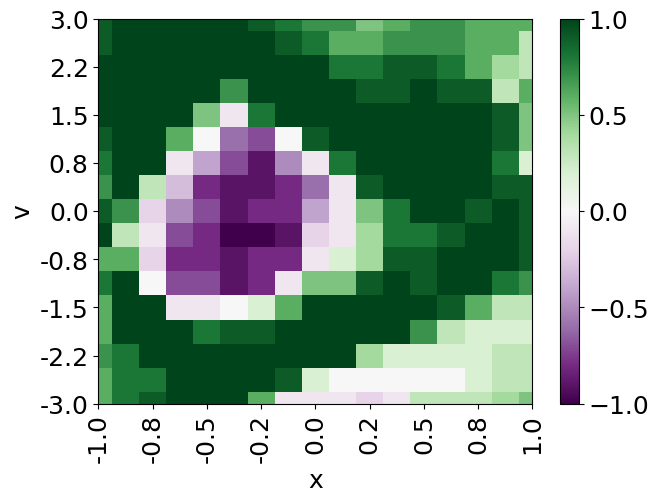

In [50]:
if show_pbo_deep:
    pbo_deep_left_q = pbo_deep_q[:, max_bellman_iterations, :, :, 0]
    pbo_deep_right_q = pbo_deep_q[:, max_bellman_iterations, :, :, 1]
    pbo_deep_pi_weighted_average = (2 * (pbo_deep_right_q > pbo_deep_left_q).mean(axis=0) - 1)
    # pbo_deep_pi_weighted_average *= samples_mask

    q_visu_mesh.set_values(pbo_deep_pi_weighted_average)
    q_visu_mesh.show("", xlabel="x", ylabel="v", plot=False, ticks_freq=2)
    _ = plt.savefig(f"figures/{experiment_name}/pbo_deep_pi_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to optimal value function

In [28]:
if show_fqi:
    fqi_v_mean = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
    fqi_v_std = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
    fqi_v_confidence_interval = confidence_interval(fqi_v_mean, fqi_v_std, n_seeds)

if show_pbo_linear:
    pbo_linear_v_mean = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
    pbo_linear_v_std = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
    pbo_linear_v_confidence_interval = confidence_interval(pbo_linear_v_mean, pbo_linear_v_std, n_seeds)

if show_pbo_deep:
    pbo_deep_v_mean = np.sqrt(np.mean(np.square(pbo_deep_v - optimal_v) * samples_mask, axis=(2, 3))).mean(axis=0)
    pbo_deep_v_std = np.sqrt(np.mean(np.square(pbo_deep_v - optimal_v) * samples_mask, axis=(2, 3))).std(axis=0)
    pbo_deep_v_confidence_interval = confidence_interval(pbo_deep_v_mean, pbo_deep_v_std, n_seeds)

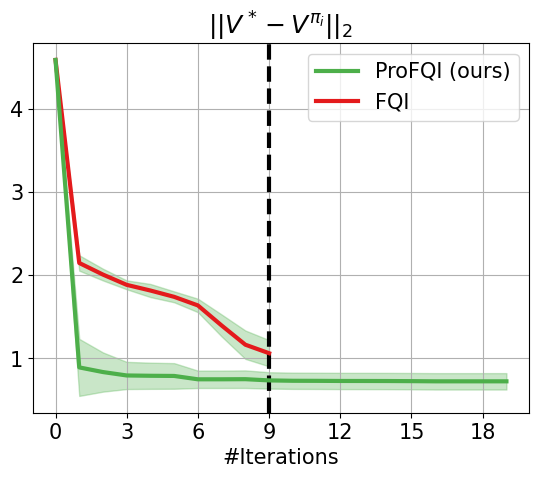

In [29]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_v_mean[:-1], label="linear PBO", color="blue", zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, :-1], pbo_linear_v_confidence_interval[1, :-1], color="blue", alpha=0.3)

    plt.hlines(pbo_linear_v_mean[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="linear PBO fixed point", zorder=3)
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, -1], pbo_linear_v_confidence_interval[1, -1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_v_mean, label="ProFQI (ours)", color=colors["ProFQI"], zorder=8)
    plt.fill_between(iterations_validation, pbo_deep_v_confidence_interval[0], pbo_deep_v_confidence_interval[1], color=colors["ProFQI"], alpha=0.3)

if show_fqi:
    plt.plot(iterations, fqi_v_mean, label="FQI", color=colors["FQI"], zorder=6)
    plt.fill_between(iterations, fqi_v_confidence_interval[0], fqi_v_confidence_interval[1], color=colors["ProFQI"], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$|| V^* - V^{\pi_i} ||_2$")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Value functions

In [30]:
if show_fqi:
    fqi_v_mean_performance = (fqi_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
    fqi_v_std_performance = (fqi_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
    fqi_v_confidence_interval_performance = confidence_interval(fqi_v_mean_performance, fqi_v_std_performance, n_seeds)

if show_pbo_linear:
    pbo_linear_v_mean_performance = (pbo_linear_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
    pbo_linear_v_std_performance = (pbo_linear_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
    pbo_linear_v_confidence_interval_performance = confidence_interval(pbo_linear_v_mean_performance, pbo_linear_v_std_performance, n_seeds)

if show_pbo_deep:
    pbo_deep_v_mean_performance = (pbo_deep_v * samples_mask).mean(axis=(2, 3)).mean(axis=0)
    pbo_deep_v_std_performance = (pbo_deep_v * samples_mask).mean(axis=(2, 3)).std(axis=0)
    pbo_deep_v_confidence_interval_performance = confidence_interval(pbo_deep_v_mean_performance, pbo_deep_v_std_performance, n_seeds)

optimal_v_performance = (optimal_v * samples_mask).mean()

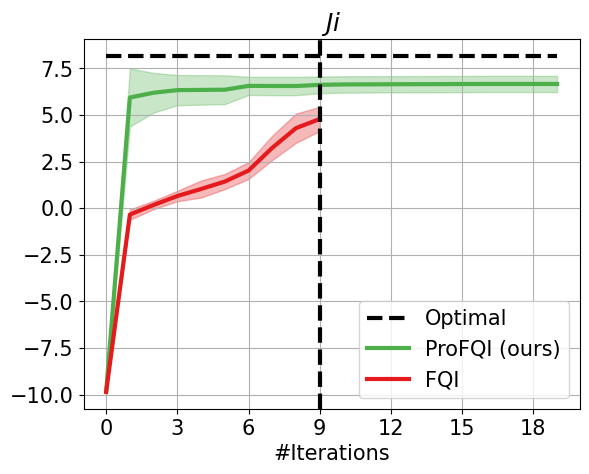

In [31]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.hlines(optimal_v_performance, 0, max_bellman_iterations_validation, color="black", linestyle="--", label="Optimal")

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_v_mean_performance[:-1], label="linear PBO", color="blue")
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_performance[0, :-1], pbo_linear_v_confidence_interval_performance[1, :-1], color="blue", alpha=0.3)

    plt.hlines(pbo_linear_v_mean_performance[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="linear PBO fixed point")
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_performance[0, -1], pbo_linear_v_confidence_interval_performance[1, -1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_v_mean_performance, label="ProFQI (ours)", color=colors["ProFQI"])
    plt.fill_between(iterations_validation, pbo_deep_v_confidence_interval_performance[0], pbo_deep_v_confidence_interval_performance[1], color=colors["ProFQI"], alpha=0.3)

if show_fqi:
    plt.plot(iterations, fqi_v_mean_performance, label="FQI", color=colors["FQI"])
    plt.fill_between(iterations, fqi_v_confidence_interval_performance[0], fqi_v_confidence_interval_performance[1], color=colors["FQI"], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.title(r"$ Ji $")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Visualization of the last value functions

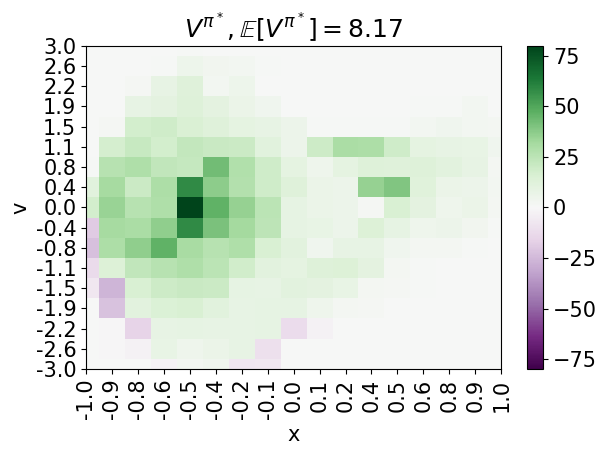

In [32]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_v_weighted_average = optimal_v * samples_mask

q_visu_mesh.set_values(optimal_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi^*}, \mathbb{E}\left[ V^{\pi^*} \right] =$" + str(np.round(np.mean(optimal_v_weighted_average), 2)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/{experiment_name}/optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

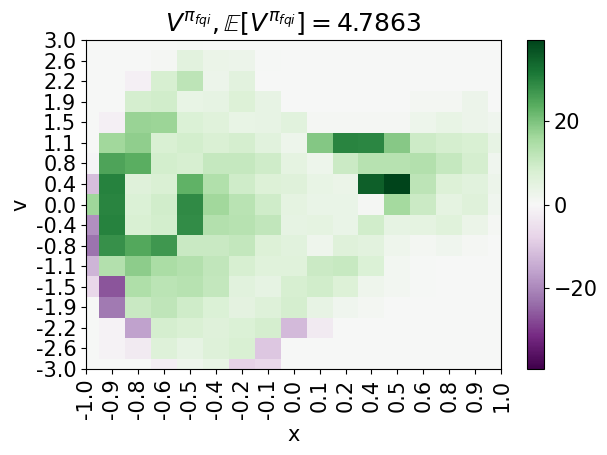

In [33]:
if show_fqi:
    fqi_v_weighted_average = fqi_v[:, -1].mean(axis=0) * samples_mask

    q_visu_mesh.set_values(fqi_v_weighted_average)
    q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + f"{np.round(np.mean(fqi_v_weighted_average), 4)}", xlabel="x", ylabel="v", plot=False)
    _ = plt.savefig(f"figures/{experiment_name}/fqi_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

In [34]:
if show_pbo_linear:
    pbo_linear_v_weighted_average = pbo_linear_v[:, max_bellman_iterations].mean(axis=0) * samples_mask

    q_visu_mesh.set_values(pbo_linear_v_weighted_average)
    q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo\_linear}} \right] =$" + str(np.round(np.mean(pbo_linear_v_weighted_average), 4)), xlabel="x", ylabel="v", plot=False)
    _ = plt.savefig(f"figures/{experiment_name}/PBO_linear_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

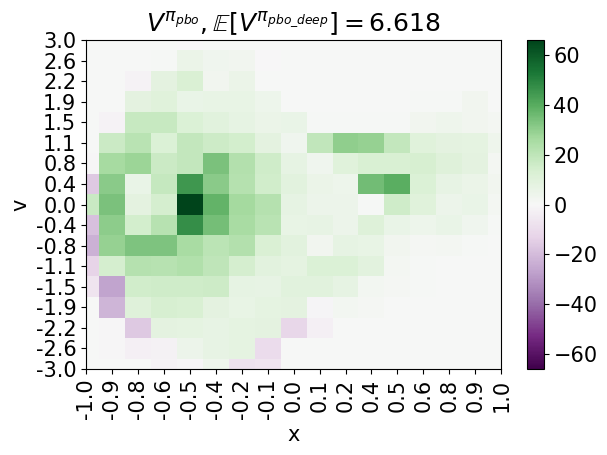

In [35]:
if show_pbo_deep:
    pbo_deep_v_weighted_average = pbo_deep_v[:, max_bellman_iterations].mean(axis=0) * samples_mask

    q_visu_mesh.set_values(pbo_deep_v_weighted_average)
    q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo\_deep}} \right] =$" + str(np.round(np.mean(pbo_deep_v_weighted_average), 4)), xlabel="x", ylabel="v", plot=False)
    _ = plt.savefig(f"figures/{experiment_name}/pbo_deep_V_{max_bellman_iterations}.pdf", bbox_inches='tight')